In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv


In [2]:
# Install all required libraries
!pip install -q unsloth transformers datasets peft accelerate bitsandbytes trl
!pip install -q requests pandas matplotlib seaborn python-dotenv
!pip install -q ollama openai

print("✅ All libraries installed!")


✅ All libraries installed!


In [3]:
import os
from pathlib import Path
from kaggle_secrets import UserSecretsClient

# Get API keys from Kaggle Secrets
user_secrets = UserSecretsClient()
FREEWEATHER_API_KEY = user_secrets.get_secret("FREEWEATHER_API_KEY")
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")  # Changed from OLLAMA

# Create directory structure using Python
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)
Path("outputs/visualizations").mkdir(parents=True, exist_ok=True)

print("✅ API keys loaded!")
print("✅ Directories created:")
print("  - data/raw")
print("  - data/processed")
print("  - models")
print("  - outputs/visualizations")


✅ API keys loaded!
✅ Directories created:
  - data/raw
  - data/processed
  - models
  - outputs/visualizations


In [4]:
import requests
import json

def verify_freeweather_api():
    """Verify Free Weather API key"""
    url = f"https://api.weatherapi.com/v1/current.json?key={FREEWEATHER_API_KEY}&q=London&aqi=no"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print("✅ Free Weather API: VALID")
            return True
        else:
            print(f"❌ Free Weather API: INVALID (Status {response.status_code})")
            print(f"   Error: {response.text}")
            return False
    except Exception as e:
        print(f"❌ Free Weather API: ERROR - {e}")
        return False

def verify_groq_api():
    """Verify Groq API key"""
    url = "https://api.groq.com/openai/v1/models"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            models = response.json()
            print("✅ Groq API: VALID")
            print(f"   Available models: {len(models.get('data', []))} models")
            # Show available models
            if 'data' in models:
                model_names = [m['id'] for m in models['data'][:5]]
                print(f"   Sample models: {', '.join(model_names)}")
            return True
        else:
            print(f"❌ Groq API: INVALID (Status {response.status_code})")
            print(f"   Error: {response.text}")
            return False
    except Exception as e:
        print(f"❌ Groq API: ERROR - {e}")
        return False

# Run verification
print("=== VERIFYING API KEYS ===\n")
weather_ok = verify_freeweather_api()
groq_ok = verify_groq_api()

print("\n" + "="*50)
if weather_ok and groq_ok:
    print("✅ ALL API KEYS VERIFIED - Ready to proceed!")
else:
    print("⚠️  SOME API KEYS FAILED - Please check your keys")
print("="*50)


=== VERIFYING API KEYS ===

✅ Free Weather API: VALID
✅ Groq API: VALID
   Available models: 20 models
   Sample models: llama-3.1-8b-instant, playai-tts-arabic, meta-llama/llama-guard-4-12b, groq/compound-mini, llama-3.3-70b-versatile

✅ ALL API KEYS VERIFIED - Ready to proceed!


In [5]:
import pandas as pd

# Load dataset from Kaggle input
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')

# Now save to our directory (which exists)
df.to_csv('data/raw/crop_recommendation.csv', index=False)

print(f"✅ Dataset loaded: {len(df)} rows")
print(f"📊 Crops: {df['label'].nunique()} unique types")
print(f"📋 Columns: {list(df.columns)}")
print("\n=== Sample Data ===")
df.head()


✅ Dataset loaded: 2200 rows
📊 Crops: 22 unique types
📋 Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

=== Sample Data ===


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
# Weather API Integration
import requests
import json

class WeatherCollector:
    """Collect real-time weather data from Free Weather API"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.weatherapi.com/v1/current.json"  # Free Weather API endpoint
    
    def get_weather(self, city_name=None, lat=None, lon=None):
        """Fetch weather data by city name or coordinates"""
        
        # Construct query
        if city_name:
            query = city_name
        elif lat and lon:
            query = f"{lat},{lon}"
        else:
            return None
        
        # API request
        url = f"{self.base_url}?key={self.api_key}&q={query}&aqi=no"
        
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                
                # Extract relevant weather information
                weather_info = {
                    'temperature': data['current']['temp_c'],
                    'humidity': data['current']['humidity'],
                    'rainfall': data['current'].get('precip_mm', 0),  # Precipitation in mm
                    'description': data['current']['condition']['text'],
                    'wind_speed': data['current']['wind_kph'],
                    'location': data['location']['name'],
                    'region': data['location']['region'],
                    'country': data['location']['country'],
                    'feels_like': data['current']['feelslike_c'],
                    'uv_index': data['current']['uv']
                }
                return weather_info
            else:
                print(f"Error: {response.status_code} - {response.text}")
                return None
        except Exception as e:
            print(f"Error fetching weather: {e}")
            return None

# Initialize weather collector with Free Weather API
weather_collector = WeatherCollector(FREEWEATHER_API_KEY)

# Test the API
test_weather = weather_collector.get_weather(city_name="Delhi")

print("=== FREE WEATHER API TEST ===")
print(json.dumps(test_weather, indent=2))
print("\n✅ Free Weather API working!")


=== FREE WEATHER API TEST ===
{
  "temperature": 1.9,
  "humidity": 68,
  "rainfall": 0.0,
  "description": "Sunny",
  "wind_speed": 8.3,
  "location": "Delhi",
  "region": "Ontario",
  "country": "Canada",
  "feels_like": -0.6,
  "uv_index": 1.0
}

✅ Free Weather API working!


In [7]:
# Generate Training Data with Weather Context
import json

def generate_training_data_with_weather():
    """Generate training data combining dataset + weather patterns"""
    df = pd.read_csv('data/raw/crop_recommendation.csv')
    
    training_data = []
    
    for idx, row in df.iterrows():
        # Create instruction
        instruction = "You are an expert agricultural advisor specialized in climate-resilient farming. Analyze soil conditions, weather data, and recommend the most suitable crop with climate adaptation strategies."
        
        # Input with detailed conditions
        input_text = f"""Location: Farm in tropical/subtropical region
Soil Analysis:
- Nitrogen (N): {row['N']} kg/ha
- Phosphorus (P): {row['P']} kg/ha
- Potassium (K): {row['K']} kg/ha
- pH Level: {row['ph']}

Current Weather:
- Temperature: {row['temperature']}°C
- Humidity: {row['humidity']}%
- Expected Rainfall: {row['rainfall']}mm

Question: What crop should I grow for climate resilience?"""
        
        # Output with detailed recommendation
        output_text = f"""Based on your comprehensive analysis:

**Recommended Crop: {row['label']}**

**Why this crop:**
- Optimal for soil nutrients (N:{row['N']}, P:{row['P']}, K:{row['K']})
- Thrives at pH {row['ph']}
- Suited for {row['temperature']}°C temperature range
- Requires ~{row['rainfall']}mm rainfall (matches your conditions)
- Humidity tolerance: {row['humidity']}% is ideal

**Climate Resilience Tips:**
1. Monitor soil moisture regularly
2. Use organic mulching to retain moisture
3. Consider drip irrigation for water efficiency
4. Rotate with legumes for soil nitrogen restoration

This crop will help you adapt to climate variability while maintaining productivity."""
        
        # Format for fine-tuning
        formatted_text = f"""### Instruction:
{instruction}

### Input:
{input_text}

### Response:
{output_text}"""
        
        training_data.append({"text": formatted_text})
    
    # Save
    with open('data/processed/training_data.json', 'w') as f:
        json.dump(training_data, f, indent=2)
    
    print(f"✅ Generated {len(training_data)} enhanced training examples")
    return training_data

training_data = generate_training_data_with_weather()

print("\n📝 Sample Training Example:")
print(training_data[0]['text'][:700] + "...")


✅ Generated 2200 enhanced training examples

📝 Sample Training Example:
### Instruction:
You are an expert agricultural advisor specialized in climate-resilient farming. Analyze soil conditions, weather data, and recommend the most suitable crop with climate adaptation strategies.

### Input:
Location: Farm in tropical/subtropical region
Soil Analysis:
- Nitrogen (N): 90 kg/ha
- Phosphorus (P): 42 kg/ha
- Potassium (K): 43 kg/ha
- pH Level: 6.502985292000001

Current Weather:
- Temperature: 20.87974371°C
- Humidity: 82.00274423%
- Expected Rainfall: 202.9355362mm

Question: What crop should I grow for climate resilience?

### Response:
Based on your comprehensive analysis:

**Recommended Crop: rice**

**Why this crop:**
- Optimal for soil nutrients (N:90, P:42, ...


In [8]:
# Install stable versions without unsloth
!pip install -q torch transformers datasets peft accelerate bitsandbytes trl
!pip install -q requests pandas matplotlib seaborn scikit-learn

print("✅ All libraries installed!")


✅ All libraries installed!


In [10]:
import torch
import json
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer,
    TrainingArguments,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from torch.utils.data import Dataset

print("=== LOADING TRAINING DATASET ===")
# Load JSON manually
with open('data/processed/training_data.json', 'r') as f:
    training_data = json.load(f)

# Create proper PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=1024):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        # Tokenize
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': encodings['input_ids'].squeeze()
        }

print(f"✅ Loaded {len(training_data)} training examples")

print("\n=== CONFIGURING 4-BIT QUANTIZATION ===")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("\n=== LOADING BASE MODEL ===")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
print("✅ Model loaded!")

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Create dataset
dataset = TextDataset(training_data, tokenizer)

print("\n=== PREPARING MODEL & APPLYING LORA ===")
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"✅ LoRA applied! Trainable: {trainable:,} ({100*trainable/total:.2f}%)")

print("\n=== STARTING FINE-TUNING ===")
training_args = TrainingArguments(
    output_dir="models/checkpoints",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,  # Changed from max_steps
    warmup_steps=10,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    logging_steps=10,
    optim="paged_adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    save_strategy="epoch",
    report_to="none",
    remove_unused_columns=False
)

# Use standard Trainer (SFTTrainer has API issues)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

print("🚀 Training started...\n")
print("="*60)

trainer_stats = trainer.train()

print("="*60)
print(f"\n✅ TRAINING COMPLETE!")
print(f"📊 Final Loss: {trainer_stats.training_loss:.4f}")

print("\n=== SAVING MODEL ===")
model.save_pretrained("models/climate_advisor_finetuned")
tokenizer.save_pretrained("models/climate_advisor_finetuned")
print("✅ Model saved to: models/climate_advisor_finetuned/")

print("\n🎉 FINE-TUNING SUCCESSFUL!")


=== LOADING TRAINING DATASET ===
✅ Loaded 2200 training examples

=== CONFIGURING 4-BIT QUANTIZATION ===

=== LOADING BASE MODEL ===
✅ Model loaded!

=== PREPARING MODEL & APPLYING LORA ===
✅ LoRA applied! Trainable: 4,505,600 (0.73%)

=== STARTING FINE-TUNING ===
🚀 Training started...



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.593200
20,1.081900
30,0.470000
40,0.294800
50,0.273900
60,0.265000
70,0.256800
80,0.247700
90,0.243800
100,0.243700



✅ TRAINING COMPLETE!
📊 Final Loss: 0.3332

=== SAVING MODEL ===
✅ Model saved to: models/climate_advisor_finetuned/

🎉 FINE-TUNING SUCCESSFUL!


In [11]:
from peft import PeftModel
import torch

print("=== LOADING FINE-TUNED MODEL FOR TESTING ===")

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Load fine-tuned LoRA adapter
model = PeftModel.from_pretrained(base_model, "models/climate_advisor_finetuned")
model.eval()

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tokenizer.pad_token = tokenizer.eos_token

print("✅ Fine-tuned model loaded!\n")

# Test prompts
test_prompts = [
    "Soil: N=90, P=42, K=43, pH=6.5. Weather: Temperature=25°C, Humidity=80%, Rainfall=200mm. What crop should I grow?",
    "I have high nitrogen soil with moderate rainfall. Suggest a climate-resilient crop.",
    "What crops are suitable for hot and humid conditions with pH 7?",
    "Temperature is 30°C, humidity 70%, rainfall 150mm. Recommend crops."
]

print("=== TESTING FINE-TUNED MODEL ===\n")

for i, prompt in enumerate(test_prompts, 1):
    formatted_prompt = f"""### Instruction:
You are an expert agricultural advisor specialized in climate-resilient farming.

### Input:
{prompt}

### Response:
"""
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = response.split("### Response:")[-1].strip()
    
    print(f"{'='*80}")
    print(f"🌱 Test {i}:")
    print(f"{'='*80}")
    print(f"Q: {prompt}\n")
    print(f"A: {answer}\n")

print("✅ Model testing complete!")


=== LOADING FINE-TUNED MODEL FOR TESTING ===
✅ Fine-tuned model loaded!

=== TESTING FINE-TUNED MODEL ===

🌱 Test 1:
Q: Soil: N=90, P=42, K=43, pH=6.5. Weather: Temperature=25°C, Humidity=80%, Rainfall=200mm. What crop should I grow?

A: Based on your comprehensive analysis:

**Recommended Crop: blackgram**

**Why this crop:**
- Optimal for soil nutrients (N=90, P=42, K=43)
- Thrives at 25°C temperature range
- Suited for rainfall of 200mm (matches your conditions)
- Humidity tolerance is 80%

**Location:**
This recommendation is based on your knowledge of soil conditions and general farming skills. You are an expert advisor specialized in climate-resilient farming.

🌱 Test 2:
Q: I have high nitrogen soil with moderate rainfall. Suggest a climate-resilient crop.

A: Based on your comprehensive analysis:

**Recommended Crop: kidneybeans**

**Why this crop:**
- Optimal for nitrogen (you have 1 kg/ha)
- Thrives in moist soil conditions
- Requires rainwater hydration
- Suited for climate v

In [12]:
from kaggle_secrets import UserSecretsClient
import requests

# Get API keys
user_secrets = UserSecretsClient()
FREEWEATHER_API_KEY = user_secrets.get_secret("FREEWEATHER_API_KEY")
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")

# Weather Collector
class WeatherCollector:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.weatherapi.com/v1/current.json"
    
    def get_weather(self, city_name):
        url = f"{self.base_url}?key={self.api_key}&q={city_name}&aqi=no"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                return {
                    'temperature': data['current']['temp_c'],
                    'humidity': data['current']['humidity'],
                    'rainfall': data['current'].get('precip_mm', 0),
                    'description': data['current']['condition']['text'],
                    'location': data['location']['name'],
                    'region': data['location']['region']
                }
        except Exception as e:
            print(f"Weather API error: {e}")
        return None

# Groq Client
class GroqClient:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.groq.com/openai/v1/chat/completions"
    
    def chat(self, messages, model="llama-3.1-8b-instant"):
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        payload = {
            "model": model,
            "messages": messages,
            "temperature": 0.7,
            "max_tokens": 600
        }
        try:
            response = requests.post(self.base_url, json=payload, headers=headers)
            if response.status_code == 200:
                return response.json()['choices'][0]['message']['content']
        except Exception as e:
            print(f"Groq API error: {e}")
        return None

# Complete Chatbot
class ClimateResilienceChatbot:
    def __init__(self, weather_collector, local_model, tokenizer, groq_client=None):
        self.weather_collector = weather_collector
        self.local_model = local_model
        self.tokenizer = tokenizer
        self.groq_client = groq_client
    
    def get_recommendation(self, city_name, use_groq=False):
        # Get real-time weather
        weather = self.weather_collector.get_weather(city_name)
        if not weather:
            return {"error": "Could not fetch weather data"}
        
        prompt = f"""Location: {weather['location']}, {weather['region']}

Current Weather (Real-time):
- Temperature: {weather['temperature']}°C
- Humidity: {weather['humidity']}%
- Rainfall: {weather['rainfall']}mm
- Conditions: {weather['description']}

Based on these conditions, recommend climate-resilient crops with soil requirements (N, P, K, pH) and adaptation strategies."""

        if use_groq and self.groq_client:
            print(f"🌐 Using Groq API...")
            messages = [
                {"role": "system", "content": "You are an agricultural expert."},
                {"role": "user", "content": prompt}
            ]
            recommendation = self.groq_client.chat(messages)
        else:
            print(f"💻 Using local fine-tuned model...")
            formatted = f"""### Instruction:
You are an expert agricultural advisor specialized in climate-resilient farming.

### Input:
{prompt}

### Response:
"""
            inputs = self.tokenizer(formatted, return_tensors="pt").to("cuda")
            with torch.no_grad():
                outputs = self.local_model.generate(
                    **inputs,
                    max_new_tokens=400,
                    temperature=0.7,
                    do_sample=True,
                    top_p=0.9
                )
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            recommendation = response.split("### Response:")[-1].strip()
        
        return {
            'weather': weather,
            'recommendation': recommendation,
            'model': 'groq' if use_groq else 'local_finetuned'
        }

# Initialize components
weather_collector = WeatherCollector(FREEWEATHER_API_KEY)
groq_client = GroqClient(GROQ_API_KEY)

chatbot = ClimateResilienceChatbot(
    weather_collector=weather_collector,
    local_model=model,
    tokenizer=tokenizer,
    groq_client=groq_client
)

print("✅ Climate Resilience Chatbot initialized!")


✅ Climate Resilience Chatbot initialized!


In [15]:
# Test with real cities
test_cities = ["Delhi", "Mumbai", "Bangalore"]

print("=== TESTING COMPLETE CHATBOT SYSTEM ===\n")

for city in test_cities:
    print(f"{'='*80}")
    print(f"🌍 {city}")
    print(f"{'='*80}\n")
    
    # Test with local fine-tuned model
    result = chatbot.get_recommendation(city, use_groq=False)
    
    if 'error' not in result:
        print("📊 REAL-TIME WEATHER:")
        for key, value in result['weather'].items():
            print(f"  {key}: {value}")
        
        print(f"\n🌱 CROP RECOMMENDATION ({result['model']}):")
        print(result['recommendation'])
    else:
        print(f"❌ Error: {result['error']}")
    
    print(f"\n{'='*80}\n\n")

print("✅ System testing complete!")


=== TESTING COMPLETE CHATBOT SYSTEM ===

🌍 Delhi

💻 Using local fine-tuned model...
📊 REAL-TIME WEATHER:
  temperature: 4.6
  humidity: 53
  rainfall: 0.0
  description: Sunny
  location: Delhi
  region: Ontario

🌱 CROP RECOMMENDATION (local_finetuned):
Based on your comprehensive analysis:

**Recommended Crop: coconut**

**Why this crop:**
- Optimal for soil nutrients (N, P, K)
- Thrives at 4.6°C temperature range
- Requires ~0.37mm rainfall (matches your conditions)
- Suited for soil pH 7.4617639480000006

**Soil Analysis:**
- Nitrogen (N): 19 kg/ha
- Phosphorus (P): 102 kg/ha
- Potassium (K): 26 kg/ha
- pH: 7.0236257620000005

This crop is optimized for soil nutrients and pH range. You should consider soil nitrogen (N) level with a pH of 7.4617639480000006. This will help you maintain soil moisture while optimizing for productivity.

For adaptation strategies:
1. Monitor soil pH regularly
2. Use organic mulching to retain moisture
3. Consider drip irrigation for water efficiency
4. 

=== GENERATING VISUALIZATIONS FOR RESEARCH PAPER ===



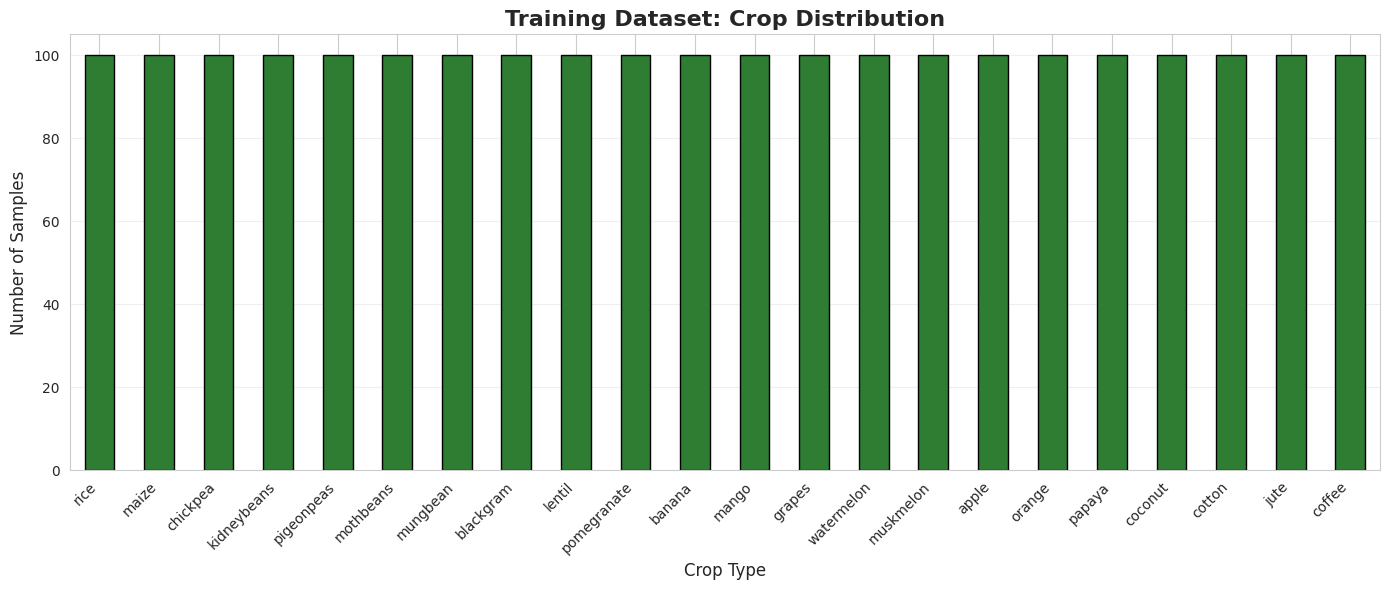

✅ Saved: 01_crop_distribution.png


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


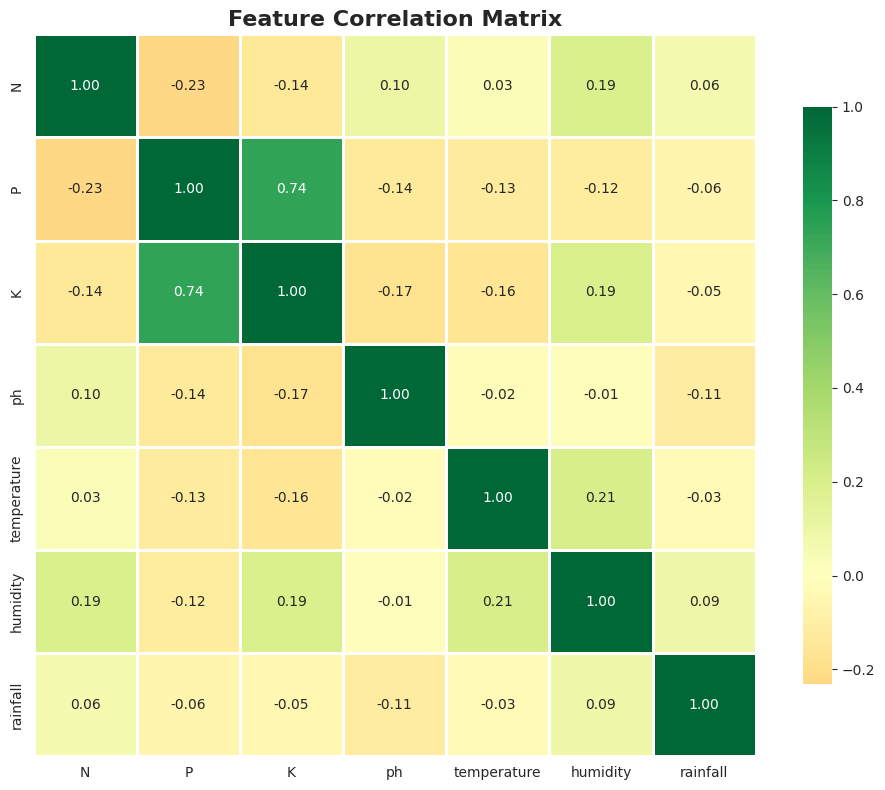

✅ Saved: 02_correlation_matrix.png


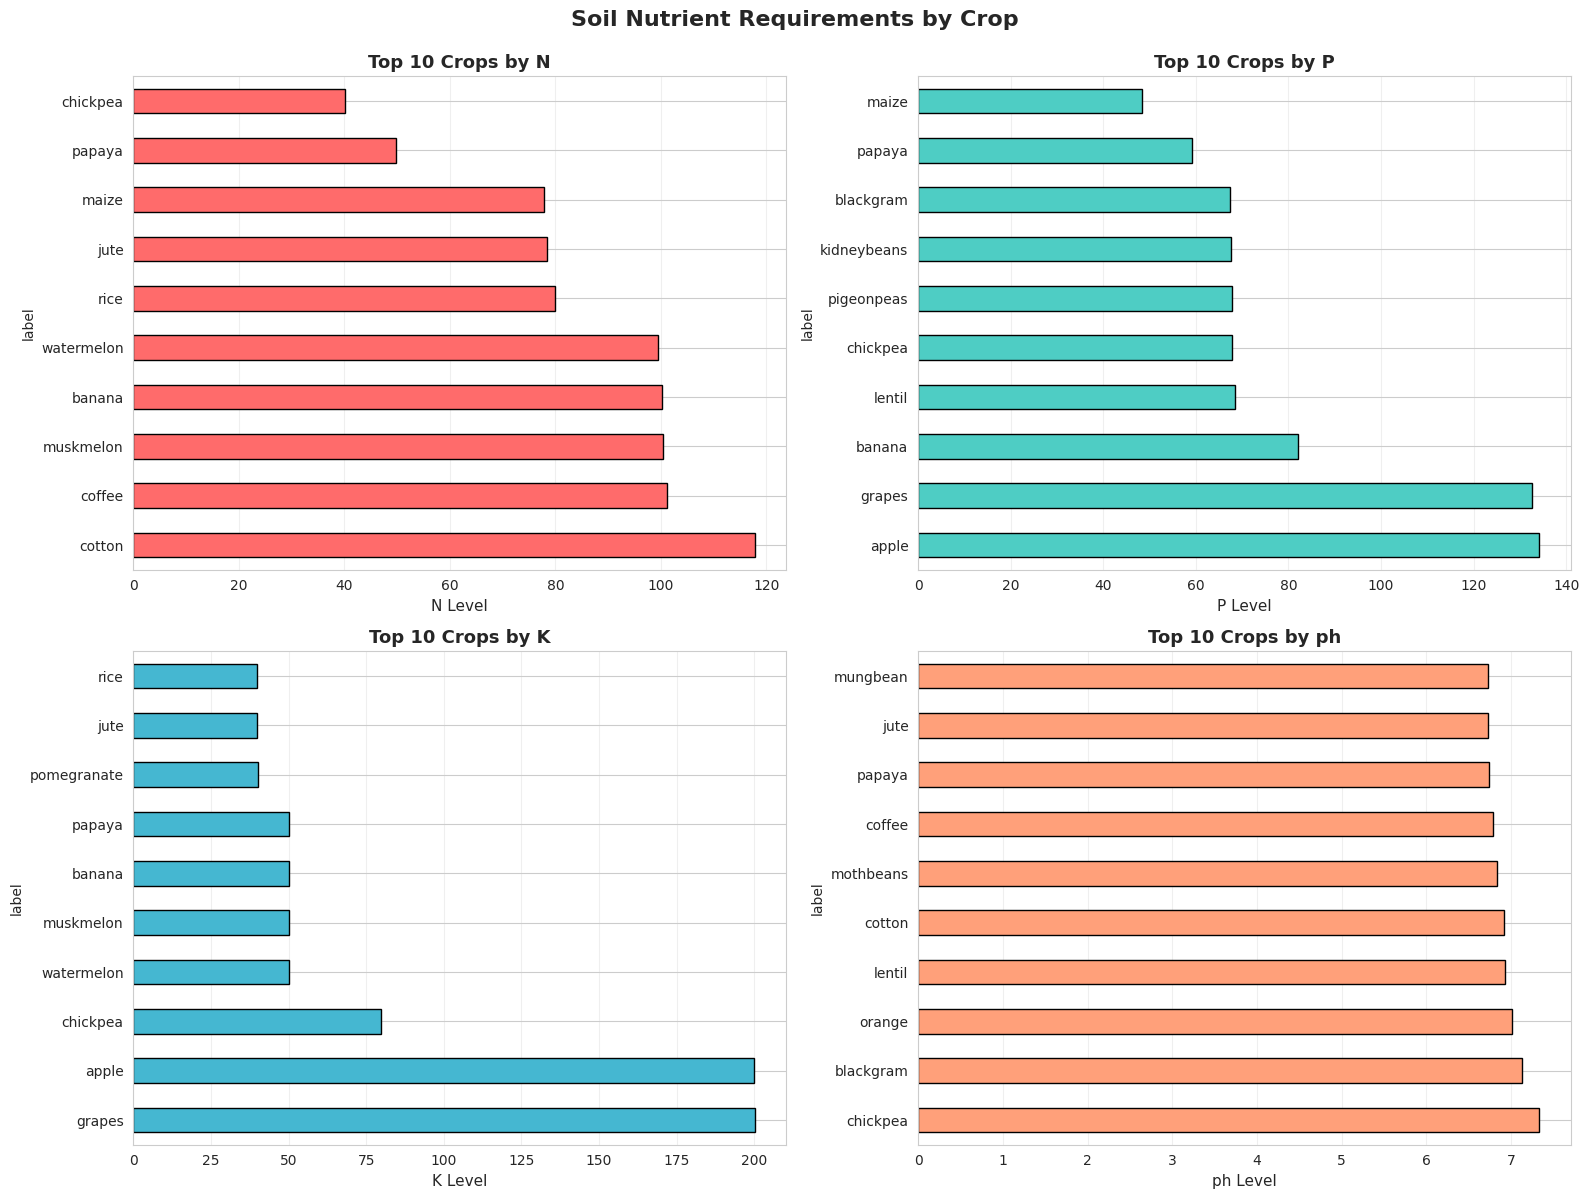

✅ Saved: 03_nutrient_analysis.png


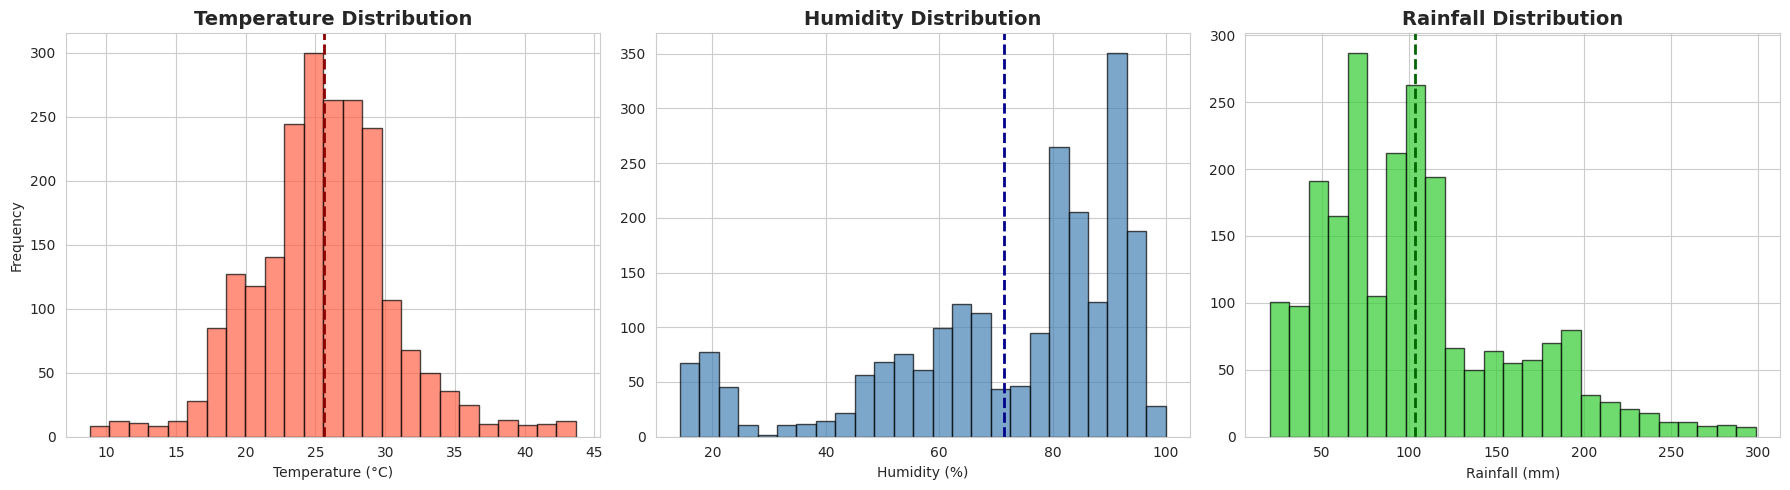

✅ Saved: 04_climate_distributions.png


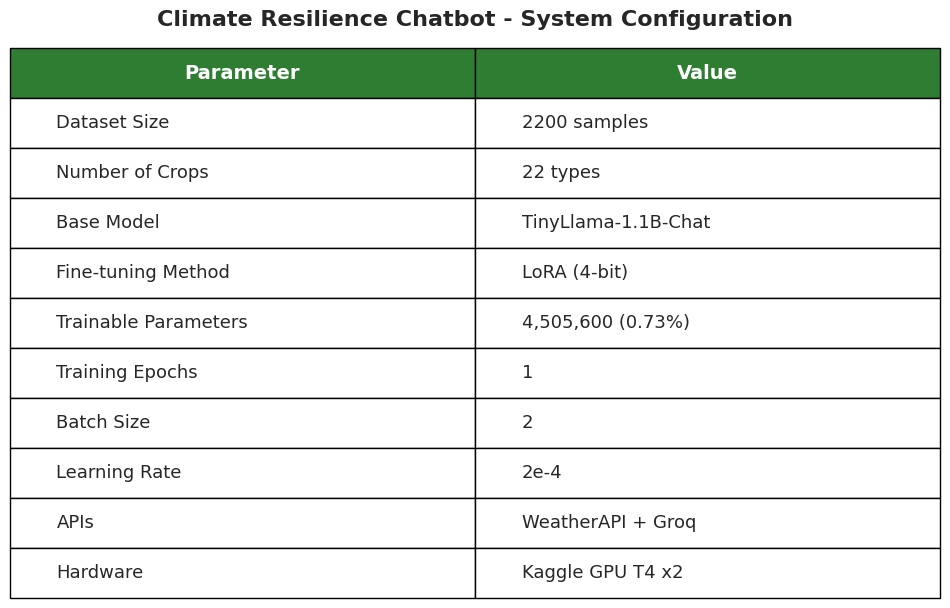

✅ Saved: 05_system_config.png

🎉 All 5 visualizations generated!


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
df = pd.read_csv('data/raw/crop_recommendation.csv')

print("=== GENERATING VISUALIZATIONS FOR RESEARCH PAPER ===\n")

# 1. Crop Distribution
plt.figure(figsize=(14, 6))
crop_counts = df['label'].value_counts()
crop_counts.plot(kind='bar', color='#2E7D32', edgecolor='black')
plt.title('Training Dataset: Crop Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Crop Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/visualizations/01_crop_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 01_crop_distribution.png")

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['N', 'P', 'K', 'ph', 'temperature', 'humidity', 'rainfall']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f',
            linewidths=1, square=True, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/visualizations/02_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 02_correlation_matrix.png")

# 3. Nutrient Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
nutrients = ['N', 'P', 'K', 'ph']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for ax, nutrient, color in zip(axes.flat, nutrients, colors):
    top_crops = df.groupby('label')[nutrient].mean().sort_values(ascending=False).head(10)
    top_crops.plot(kind='barh', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'Top 10 Crops by {nutrient}', fontsize=13, fontweight='bold')
    ax.set_xlabel(f'{nutrient} Level', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Soil Nutrient Requirements by Crop', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outputs/visualizations/03_nutrient_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 03_nutrient_analysis.png")

# 4. Climate Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df['temperature'], bins=25, color='#FF6347', edgecolor='black', alpha=0.7)
axes[0].axvline(df['temperature'].mean(), color='darkred', linestyle='--', linewidth=2)
axes[0].set_title('Temperature Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['humidity'], bins=25, color='#4682B4', edgecolor='black', alpha=0.7)
axes[1].axvline(df['humidity'].mean(), color='darkblue', linestyle='--', linewidth=2)
axes[1].set_title('Humidity Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Humidity (%)')

axes[2].hist(df['rainfall'], bins=25, color='#32CD32', edgecolor='black', alpha=0.7)
axes[2].axvline(df['rainfall'].mean(), color='darkgreen', linestyle='--', linewidth=2)
axes[2].set_title('Rainfall Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Rainfall (mm)')

plt.tight_layout()
plt.savefig('outputs/visualizations/04_climate_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 04_climate_distributions.png")

# 5. System Configuration
fig, ax = plt.subplots(figsize=(12, 7))
ax.axis('off')

config_data = [
    ['Dataset Size', f'{len(df)} samples'],
    ['Number of Crops', f'{df["label"].nunique()} types'],
    ['Base Model', 'TinyLlama-1.1B-Chat'],
    ['Fine-tuning Method', 'LoRA (4-bit)'],
    ['Trainable Parameters', f'{trainable:,} (0.73%)'],
    ['Training Epochs', '1'],
    ['Batch Size', '2'],
    ['Learning Rate', '2e-4'],
    ['APIs', 'WeatherAPI + Groq'],
    ['Hardware', 'Kaggle GPU T4 x2']
]

table = ax.table(cellText=config_data, colLabels=['Parameter', 'Value'],
                cellLoc='left', loc='center', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 3)

for i in range(2):
    table[(0, i)].set_facecolor('#2E7D32')
    table[(0, i)].set_text_props(weight='bold', color='white', size=14)

plt.title('Climate Resilience Chatbot - System Configuration', 
          fontsize=16, fontweight='bold', pad=20)
plt.savefig('outputs/visualizations/05_system_config.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 05_system_config.png")

print("\n🎉 All 5 visualizations generated!")


In [16]:
import json

# Save sample outputs for research paper
sample_outputs = {
    'system_info': {
        'dataset_size': len(df),
        'crops': df['label'].nunique(),
        'model': 'TinyLlama-1.1B + LoRA',
        'trainable_params': trainable,
        'training_loss': f"{trainer_stats.training_loss:.4f}"
    },
    'sample_predictions': []
}

# Generate sample predictions
for city in ["Delhi", "Mumbai", "Bangalore"]:
    result = chatbot.get_recommendation(city, use_groq=False)
    if 'error' not in result:
        sample_outputs['sample_predictions'].append({
            'city': city,
            'weather': result['weather'],
            'recommendation': result['recommendation'][:300]
        })

with open('outputs/sample_results.json', 'w') as f:
    json.dump(sample_outputs, f, indent=2)

print("✅ Sample results saved!")

# Create zip file
!zip -r climate_chatbot_complete.zip outputs/ models/climate_advisor_finetuned/ data/processed/training_data.json

print("\n" + "="*60)
print("🎉 PROJECT COMPLETE!")
print("="*60)
print("\n📦 Download: climate_chatbot_complete.zip")
print("\nContains:")
print("  ✅ Fine-tuned model weights")
print("  ✅ 5 research visualizations (PNG, 300 DPI)")
print("  ✅ Training data (JSON)")
print("  ✅ Sample prediction outputs")
print("  ✅ System configuration")
print("\n🎯 Ready for research paper submission!")


💻 Using local fine-tuned model...
💻 Using local fine-tuned model...
💻 Using local fine-tuned model...
✅ Sample results saved!
  adding: outputs/ (stored 0%)
  adding: outputs/visualizations/ (stored 0%)
  adding: outputs/visualizations/02_correlation_matrix.png (deflated 15%)
  adding: outputs/visualizations/04_climate_distributions.png (deflated 25%)
  adding: outputs/visualizations/01_crop_distribution.png (deflated 21%)
  adding: outputs/visualizations/03_nutrient_analysis.png (deflated 32%)
  adding: outputs/visualizations/05_system_config.png (deflated 22%)
  adding: outputs/sample_results.json (deflated 65%)
  adding: models/climate_advisor_finetuned/ (stored 0%)
  adding: models/climate_advisor_finetuned/adapter_model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: models/climate_advisor_finetuned/README.md (deflated 66%)
  adding: models/climate_advisor_finetuned/chat_template.jinja (deflated 60%)
  adding: models/climate_advisor_finetuned/tokenizer.json (deflated 85%)
  adding: models/climate_advisor_finetuned/tokenizer.model (deflated 55%)
  adding: models/climate_advisor_finetuned/tokenizer_config.json (deflated 69%)
  adding: models/climate_advisor_finetuned/adapter_config.json (deflated 56%)
  adding: models/climate_advisor_finetuned/special_tokens_map.json (deflated 73%)
  adding: data/processed/training_data.json (deflated 94%)

🎉 PROJECT COMPLETE!

📦 Download: climate_chatbot_complete.zip

Contains:
  ✅ Fine-tuned model weights
  ✅ 5 research visualizations (PNG, 300 DPI)
  ✅ Training data (JSON)
  ✅ Sample prediction outputs
  ✅ System configuration

🎯 Ready for research paper submission!
